In [1]:
import os
import numpy as np
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import wandb
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score

/opt/conda/envs/classification/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
seed_everything(42)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda Tesla V100-PCIE-32GB


In [5]:
## 초기 설정 -> 연예인 리스트, batch size, epochs, lr, ...
exp_name = 'Cropped1024_det256_min60_FIRST_efficientnet_b7'
dataset_path = '/opt/ml/Cropped1024_det256_min60_FIRST'  

val_saved = 1 # 1에폭마다 저장

batch_size = 8  # Mini-batch size
num_epochs = 30
learning_rate = 0.0001

In [6]:
train_csv_path = os.path.join(dataset_path, 'train.csv')
valid_csv_path = os.path.join(dataset_path, 'valid.csv')
actor_csv_path = os.path.join(dataset_path, 'actor.csv')
num_actor_csv_path = os.path.join(dataset_path, 'num_actor.csv')

saved_path = os.path.join(dataset_path, 'saved', exp_name)
os.makedirs(saved_path, exist_ok=True)

train_df = pd.read_csv(train_csv_path)
valid_df = pd.read_csv(valid_csv_path)
actor_df = pd.read_csv(actor_csv_path)
num_actor_df = pd.read_csv(num_actor_csv_path)

train_df.head()

,Unnamed: 0,path,name
0,0,images/강하늘/강하늘_000.jpg,강하늘
1,1,images/강하늘/강하늘_001.jpg,강하늘
2,2,images/강하늘/강하늘_002.jpg,강하늘
3,3,images/강하늘/강하늘_003.jpg,강하늘
4,4,images/강하늘/강하늘_005.jpg,강하늘


In [7]:
valid_df.head()

,Unnamed: 0,path,name
0,0,images/강하늘/강하늘_004.jpg,강하늘
1,1,images/강하늘/강하늘_013.jpg,강하늘
2,2,images/강하늘/강하늘_017.jpg,강하늘
3,3,images/강하늘/강하늘_031.jpg,강하늘
4,4,images/강하늘/강하늘_036.jpg,강하늘


In [8]:
celeb_list = actor_df['name'].tolist()
celeb_list

['강하늘',
 '곽동연',
 '신민아',
 '임윤아',
 '로몬',
 '김선호',
 '안효섭',
 '김혜수',
 '원진아',
 '황인엽',
 '진서연',
 '박하선',
 '변요한',
 '이준',
 '박서준',
 '공명',
 '차승원',
 '안보현',
 '정유미',
 '박해진',
 '최시원',
 '이광수',
 '권나라',
 '서지혜',
 '정은지',
 '최현욱',
 '윤균상',
 '홍종현',
 '고민시',
 '박지현',
 '이상이',
 '이성경',
 '정해인',
 '남상미',
 '김고은',
 '이준호',
 '서현진',
 '유지태',
 '지창욱',
 '김우빈',
 '전여빈',
 '천우희',
 '오연수',
 '이엘리야',
 '박신혜',
 '류승룡',
 '보나',
 '송하윤',
 '이선빈',
 '최우식',
 '이시영',
 '유아인',
 '한지민',
 '주지훈',
 '윤찬영',
 '이시언',
 '김보라',
 '남주혁',
 '이병헌',
 '김무열',
 '손담비',
 '손석구',
 '송혜교',
 '김성철',
 '찬희',
 '박지후',
 '박주현',
 '전미도',
 '공효진',
 '김동희',
 '김대명',
 '이도현',
 '장혁',
 '김민규',
 '조정석',
 '이태리',
 '정우성',
 '한선화',
 '설현',
 '진기주',
 '신혜선',
 '김래원',
 '조현철',
 '정혜성',
 '표예진',
 '공유',
 '조이현',
 '백현',
 '박민영',
 '차주영',
 '이정재',
 '김지원',
 '유인나',
 '손예진',
 '박해수',
 '강훈',
 '최성은',
 '김태리',
 '원지안',
 '옥택연',
 '이상윤',
 '김희선',
 '이영은',
 '김현주',
 '김지은',
 '장희진',
 '안재홍',
 '육성재',
 '정호연',
 '여진구',
 '진구',
 '채종협',
 '이선균',
 '나인우',
 '김정현',
 '조병규',
 '김다미',
 '남궁민',
 '임수향',
 '배두나',
 '김지석',
 '수애',
 '정다빈',
 '이보영',
 '서하준',
 '이수혁',
 '김

In [10]:
num_actor_df.sum()

Unnamed: 0                                                15225
valid_num                                                 10172
train_num                                                 41049
total_num                                                 51221
name          강하늘곽동연신민아임윤아로몬김선호안효섭김혜수원진아황인엽진서연박하선변요한이준박서준공명차...
dtype: object

In [11]:
class CustomDataset(Dataset):
    def __init__(self, df, mode='train', transform=None):
        self.df = df
        self.mode = mode
        self.transform = transform

    def __getitem__(self, idx):

        img_path = os.path.join(dataset_path, self.df['path'][idx])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed['image']

        if self.mode in ('train', 'val'):
            label = self.df['name'][idx]
            label = celeb_list.index(label)
            
            return img, label

        elif self.mode == 'test':
            return img
    
    def __len__(self):
        return len(self.df)

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            # A.LongestMaxSize(380),
                            # A.PadIfNeeded(380, 380, border_mode = cv2.BORDER_CONSTANT),
                            A.Resize(600, 600, interpolation = cv2.INTER_AREA, p = 1), ## INTER_AREA => 축소에 좋음
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                        #   A.LongestMaxSize(380),
                        #   A.PadIfNeeded(380, 380, border_mode = cv2.BORDER_CONSTANT),
                          A.Resize(600, 600, interpolation = cv2.INTER_AREA, p = 1),
                          ToTensorV2()
                          ])

#  	        B0	    B1	    B2	    B3	    B4    	B5    	B6    	B7
# Input	    224	    240	    260	    300	    380	    456	    528	    600
# output	  1280	  1280  	1408  	1536  	1792  	2048  	2304  	2560                  

In [13]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

## dataset 구성
train_dataset = CustomDataset(train_df, mode="train", transform=train_transform)

# 나중에 train_df -> val_df
val_dataset = CustomDataset(valid_df, mode="val", transform=val_transform)

# test_dataset = CustomDataset(test_df, mode="test", transform=test_transform)

## dataloader 구성
train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4
        )
val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4
        )

노정의
torch.Size([3, 600, 600])


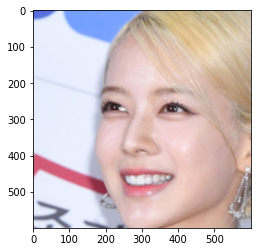

In [14]:
## 잘 나오는 지 중간 테스트 (필요에 따라 사용하시면 욀 것 같습니다.)
for img, label in train_loader:
    temp_img = img
    temp_label = label
    print(celeb_list[temp_label[0]])
    break
print(temp_img[0].shape)
plt.imshow(temp_img[0].permute([1,2,0]))    


In [15]:
print(torchvision.__path__)

['/opt/conda/envs/classification/lib/python3.7/site-packages/torchvision']


In [16]:
## model 정의 (원하는 모델로 바꾸면 될 것 같습니다!)
model = torchvision.models.efficientnet_b7(pretrained = True)
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [17]:

model.classifier[1] = nn.Linear(in_features=2560, out_features=len(celeb_list), bias=True) #b7
# model.classifier[1] = nn.Linear(in_features=1280, out_features=len(celeb_list), bias=True) #b0
# model.classifier[1] = nn.Linear(in_features=1792, out_features=len(celeb_list), bias=True) #b4
#  	        B0	    B1	    B2	    B3	    B4    	B5    	B6    	B7
# Input	    224	    240	    260	    300	    380	    456	    528	    600
# output	1280	1280	1408	1536	1792	2048	2304	2560


In [18]:
# model.load_state_dict(torch.load(saved_path))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.5, 0.999))

In [22]:
wandb.login()

wandb.init(project='final-project', entity='cv-3-bitcoin', name=exp_name, config={"epochs": num_epochs, "batch_size": batch_size, "lr":learning_rate})


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sunhyukpark (cv-3-bitcoin). Use `wandb login --relogin` to force relogin


In [23]:
## train & validation
best_f1 = 1e10
for epoch in tqdm(range(num_epochs)):
    print("\nEpoch ", epoch+1)
    
    ## train
    print("\nTrain:")
    model.train()
    train_loss = 0
    for i, (img, label) in enumerate(train_loader): 
        img, label = img.to(device), label.to(device)
        pred = model(img)
        loss = criterion(pred, label)    
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 3) == 1) or i+1 == len(train_loader):
            display_loss = '[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1))
            print(display_loss)
        
            wandb.log({'train loss': train_loss/(i+1)})
            
    ## validation
    print("\nValidation:")
    with torch.no_grad():
        model.eval()
        val_loss = 0
        total = 0
        correct = 0
        label_list = []
        pred_list = []
        
        for i, (img, label) in enumerate(val_loader):
            img, label = img.to(device), label.to(device)
            pred = model(img)
            loss = criterion(pred, label)    
            val_loss += loss.item()

            _, predicted = pred.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()
            label_list.append(label)
            pred_list.append(predicted)

            if ((i+1) % (len(val_loader) // 3) == 1) or i+1 == len(val_loader):
                display_loss = '[%3d/%3d] | Loss: %.5f'%(i+1, len(val_loader), val_loss/(i+1))
                print(display_loss)
                wandb.log({'val loss': val_loss/(i+1)})

        f1 = f1_score(torch.cat(label_list).to('cpu'), torch.cat(pred_list).to('cpu'), average = 'macro')
        print(f"Acc: {100.*correct / total:.2f}%")
        print(f"F1_score: {f1:.4f}")
        wandb.log({"f1 score": f1, 'accuracy': correct / total})
        
        

    if (epoch % val_saved) == val_saved-1:
        print(f"Epoch {epoch+1} is saved!")
        torch.save(model.state_dict(), os.path.join(saved_path, f'epoch_{epoch+1}.pt'))
    
    if best_f1 < f1:
        print(f"f1 is minimum! | will be saved!")
        torch.save(model.state_dict(), os.path.join(saved_path, f'best_f1.pt'))
        best_f1 = f1
wandb.finish()

  0%|          | 0/30 [00:00<?, ?it/s]


Epoch  1

Train:
[  1/1300] | Loss: 5.20228
[434/1300] | Loss: 4.87465
[867/1300] | Loss: 4.41745
[1300/1300] | Loss: 3.94336

Validation:
[  1/322] | Loss: 2.01119
[108/322] | Loss: 2.11118
[215/322] | Loss: 2.13222
[322/322] | Loss: 2.11975
Acc: 50.49%
F1_score: 0.45

Epoch  2

Train:
[  1/1300] | Loss: 2.45661
[434/1300] | Loss: 2.11544
[867/1300] | Loss: 1.88810
[1300/1300] | Loss: 1.69870

Validation:
[  1/322] | Loss: 0.88587
[108/322] | Loss: 0.90781
[215/322] | Loss: 0.88634
[322/322] | Loss: 0.88005
Acc: 78.31%
F1_score: 0.76

Epoch  3

Train:
[  1/1300] | Loss: 0.78038
[434/1300] | Loss: 0.96976
[867/1300] | Loss: 0.91229
[1300/1300] | Loss: 0.86217

Validation:
[  1/322] | Loss: 0.76229
[108/322] | Loss: 0.54227
[215/322] | Loss: 0.55255
[322/322] | Loss: 0.53510
Acc: 86.76%
F1_score: 0.85

Epoch  4

Train:
[  1/1300] | Loss: 0.39524
[434/1300] | Loss: 0.55176
[867/1300] | Loss: 0.54954
[1300/1300] | Loss: 0.53742

Validation:
[  1/322] | Loss: 0.47406
[108/322] | Loss: 0.4

accuracy,▁▅▇▇▇█████████████████████████
f1 score,▁▅▇▇▇█████████████████████████
train loss,█▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,██▄▃▃▂▂▂▃▂▂▂▁▂▂▂▂▂▂▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂
accuracy,0.95185
f1 score,0.94645
train loss,0.01974
val loss,0.34232


In [24]:
## grad CAM
def CAM(fm, w, pred, shape):
    """
    feature_map: [1280, 16, 12]
    classfier weight: [18, 1280]
    image: [3, 512, 384]
    """
    img_shape = shape[1], shape[2]
    cm = w[pred]**2 @ fm.view(fm.shape[0], -1) # [16 * 12]
    cm = cm.view(fm.shape[1], fm.shape[2]) # [16, 12]
    cm = cm - torch.min(cm)
    cm = cm / torch.max(cm) # 0 ~ 1
    cm = torchvision.transforms.ToPILImage()(cm)
    cm = torchvision.transforms.Resize(img_shape)(cm)
    return cm

cam_transform = A.Compose([
                        ToTensorV2()
                        ])

(-0.5, 379.5, 379.5, -0.5)

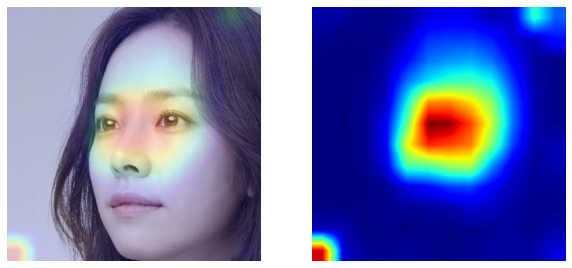

In [27]:
img_path = '/opt/ml/cropped_det_256_min_60/images/한지민/한지민_001.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img /= 255.0

transformed = cam_transform(image=img)
img = transformed['image']
shape = img.shape

model = model.to(device)
feature_map = model.features(img.unsqueeze(0).to(device)).to('cpu').detach().squeeze()
weight = list(model.classifier.parameters())[0].to('cpu')
pred_cls = model(img.unsqueeze(0).to(device)).argmax()

cam_img = CAM(feature_map, weight, pred_cls, shape)

fig = plt.figure(figsize = (10, 10))
plt.jet()
ax = fig.add_subplot(121)

ax.imshow(img.permute([1,2,0]))
ax.imshow(cam_img, alpha = 0.2)
ax.axis('off')

ax = fig.add_subplot(122)
ax.imshow(cam_img)
ax.axis('off')

In [28]:
valid_df.head()

,Unnamed: 0,path,name
0,0,images/정다빈/정다빈_019.jpg,정다빈
1,1,images/정다빈/정다빈_020.jpg,정다빈
2,2,images/정다빈/정다빈_021.jpg,정다빈
3,3,images/정다빈/정다빈_023.jpg,정다빈
4,4,images/정다빈/정다빈_031.jpg,정다빈


0it [00:00, ?it/s]

옥택연
옥택연
tensor([ 43, 163, 151, 135, 174,  23,  90, 134, 179,  52, 138,  95,  31, 161,
         30,  16,  86, 163, 131, 115, 160, 101, 140,  65, 129, 103,  52,  33,
         49,  32,  36, 160], device='cuda:0')
tensor([ 43, 163, 174, 135, 174,  23,  90, 134, 179,  52, 138,  95,  31, 161,
         30,  16,  86, 163, 131, 115, 165, 101, 140,  65, 129, 103,  52,  33,
         49,  32,  36, 160], device='cuda:0')


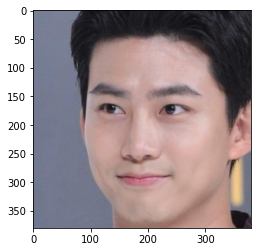

In [29]:
## validation 틀린 부분 시각화
model.eval()
incorrect_img_list = []
incorrect_label_list = []
label_list = []
pred_list = []

for i, (img, label) in tqdm(enumerate(val_loader)):
    img, label = img.to(device), label.to(device)
    pred = model(img) 

    _, predicted = pred.max(1)

    for i in range(batch_size):
        if label[i] != predicted[i]:
            incorrect_img_list.append(img[i])
            incorrect_label_list.append((label[i], predicted[i]))
    
    print(celeb_list[label[0]])
    print(celeb_list[predicted[0]])
    plt.imshow(img[0].permute([1,2,0]).to('cpu'))
    print(label)
    print(predicted)
    break
    label_list.append(label)
    pred_list.append(predicted)


# plt.imshow(temp_img[0].permute([1,2,0]))

In [19]:
test_transform = A.Compose([
                           ToTensorV2()
                           ])
test_dataset = CustomDataset(test_df, mode="test", transform=test_transform)

test_label = []
fig = plt.figure(figsize = (40, 60))
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, 8*i+j + 1)
        plt.imshow(Image.open(test_set[8*i+j]))
        sample = test_set[8*i+j]
        lb = model(config.val_augmentation(Image.open(sample)).unsqueeze(0).to(device)).argmax()
        lb = int(lb)
        plt.axis('off')
        plt.title(f"Pred: {lb}", fontsize = 30)
fig.subplots_adjust(wspace=0, hspace=0.1)

NameError: name 'test_df' is not defined